In [ ]:
#TODO SISTEMO CODICE E AGGIUNGO COMMENTI 

# Requirement 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pricing_environment import PricingEnvironment
from Demand_curve_generator import Demand_curve_generator as demand

from scipy import optimize
from bidding_environment import FirstPriceAuction
from bidding import HedgeAgent, FFMultiplicativePacingAgent
from Competing_bids_generator import generate_bids

import warnings
warnings.filterwarnings("ignore")

## PRICING

Hedge agent

In [10]:
n_trials = 50

regret_per_trial = []
pseudo_regret_per_trial = []

for seed in range(n_trials):
    np.random.seed(seed)
    T = 10000 # number of days
    epsilon = T**(-0.33)
    K =  int(1/epsilon) # number of actions
    n_customers = 100 # this will depend on advertising step when combining bidding and pricing
    learning_rate = np.sqrt(np.log(K)/T)


    prices = np.linspace(0,1,K)
    cost = 0.1 

    conversion_rates = []
    random_steeps = np.random.uniform(1,5,T) # generates T parameters for the demand curve 1 for each day
    conversion_rates = [demand.generate_demand(0,1,steep) for steep in random_steeps]

    reward_function = lambda price, n_sales: (price-cost)*n_sales
    maximum_profit = reward_function(max(prices), n_customers) # the maximum possible reward is selling at the maximum price to every possible customer


    loss_profit_curve = []
    for t in range(T):
        loss_profit_curve.append([(1-(price-cost)*conversion_rates[t](price)) for price in prices])
    loss_profit_curve = np.array(loss_profit_curve)
    summed_losses = np.sum(loss_profit_curve, axis=0)
    best_price_index = np.argmin(summed_losses)
    best_price = prices[best_price_index]
    clairvoyant_losses = loss_profit_curve[:,best_price_index] # Best arm in Hindsight

    np.random.seed(seed)
    env = PricingEnvironment(conversion_probability=conversion_rates, cost=cost, prices=prices)
    Hedge_agent = HedgeAgent(K, learning_rate)

    agent_losses = np.array([])
    expected_agent_losses = np.array([])


    for t in range(T):
        pi_t = Hedge_agent.pull_arm()
        p_t = prices[pi_t] 
        l_t, r_t, d_t = env.round(p_t, n_customers, t)
        Hedge_agent.update(l_t)

        agent_losses = np.append(agent_losses, l_t[pi_t])
        expected_agent_losses = np.append(expected_agent_losses, np.dot(l_t, Hedge_agent.x_t))


    cumulative_regret = np.cumsum(agent_losses-clairvoyant_losses)
    cumulative_pseudo_regret = np.cumsum(expected_agent_losses-clairvoyant_losses)

    regret_per_trial.append(cumulative_regret)
    pseudo_regret_per_trial.append(cumulative_pseudo_regret)

regret_per_trial = np.array(regret_per_trial)
pseudo_regret_per_trial = np.array(pseudo_regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)
average_pseudo_regret = pseudo_regret_per_trial.mean(axis=0)
pseudo_regret_std = pseudo_regret_per_trial.std(axis=0)

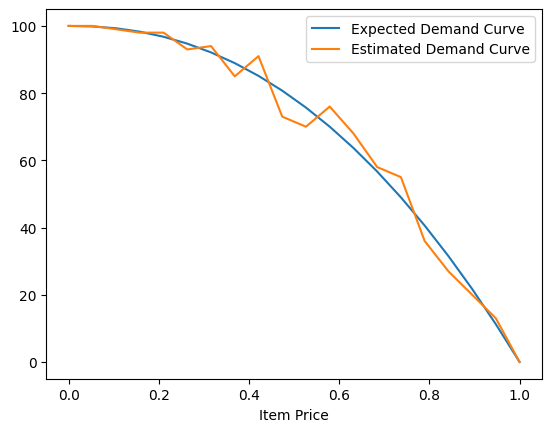

In [11]:
conversion_probability = conversion_rates[0] # We take only the first conversion_probability as an example

expected_demand_curve = n_customers*conversion_probability(prices)

estimated_demand_curve = np.random.binomial(n_customers, conversion_probability(prices))

plt.figure()
plt.plot(prices, expected_demand_curve, label='Expected Demand Curve')
plt.plot(prices, estimated_demand_curve, label='Estimated Demand Curve')
plt.xlabel('Item Price')
plt.legend()
plt.show();

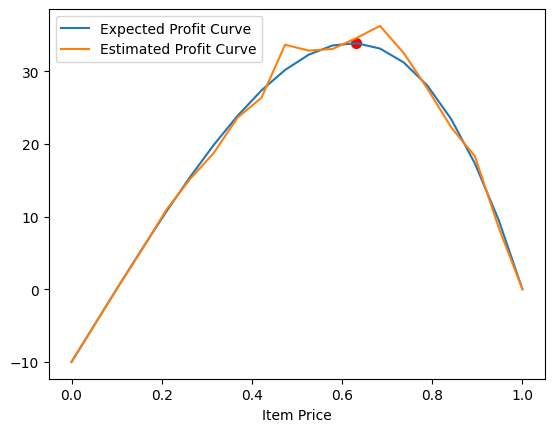

In [12]:
expected_profit_curve = n_customers*conversion_probability(prices)*(prices-cost)

estimated_profit_curve = np.random.binomial(n_customers, conversion_probability(prices))*(prices-cost)

plt.figure()
plt.plot(prices, expected_profit_curve, label='Expected Profit Curve')
plt.plot(prices, estimated_profit_curve, label='Estimated Profit Curve')
plt.scatter(best_price, expected_profit_curve[best_price_index], color='red', s=50)
plt.xlabel('Item Price')
plt.legend()
plt.show();

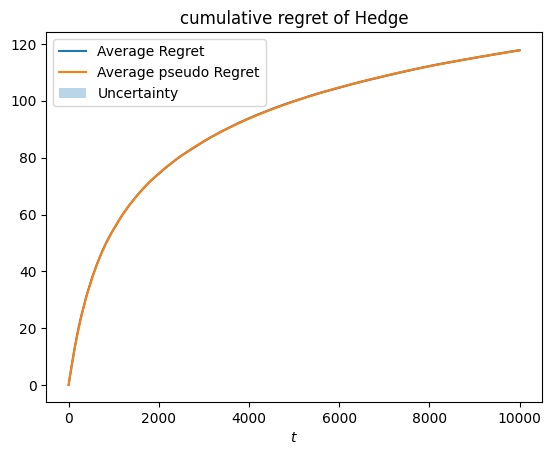

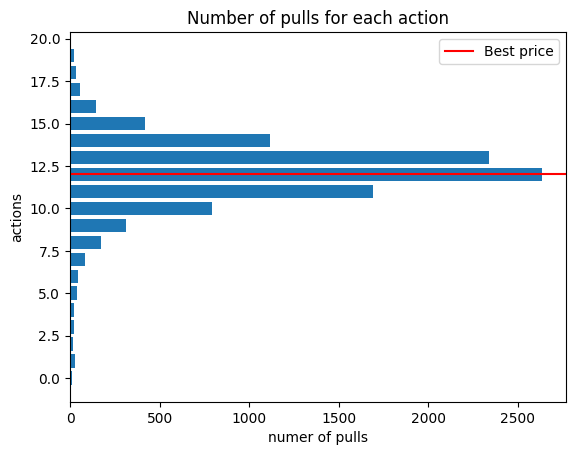

In [15]:
plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.plot(np.arange(T), average_pseudo_regret, label='Average pseudo Regret')
plt.title('cumulative regret of Hedge')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.xlabel('$t$')
plt.legend()
plt.show()

plt.figure()
plt.barh(np.arange(K), Hedge_agent.N_pulls)
plt.axhline(best_price_index, color='red', label='Best price')
plt.ylabel('actions')
plt.xlabel('numer of pulls')
plt.legend()
plt.title('Number of pulls for each action')
plt.show();

## BIDDING

MULTIPLICATIVE PACING

In [2]:
# First Price Auction
n_advertisers = 3
n_users = 10000
Budget = 500
my_valuation = 0.6
rho = Budget/n_users
eta = 1/np.sqrt(n_users) # from theory


# Generate competing bids
np.random.seed(57)
other_bids = np.array([generate_bids(n_advertisers, np.random.normal(0.5, 5), t) for t in range(n_users)]).T
other_bids[:,1000:3000] = np.random.uniform(0,1)
other_bids[:,5000:7000] = np.random.uniform(0,1)
other_bids[:,9000:] = np.random.uniform(0,1)
m_t = other_bids.max(axis=0)


# Clairvoyant results
available_bids = np.linspace(0,1,11)
win_probabilities = np.array([sum(b > m_t)/n_users for b in available_bids])
c = -(my_valuation-available_bids)*win_probabilities
A_ub = [available_bids*win_probabilities]
b_ub = [rho]
A_eq = [np.ones(len(available_bids))]
b_eq = [1]
res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
gamma = res.x # optimal bidding random strategy
expected_clairvoyant_utilities = [-res.fun for u in range(n_users)]
expected_clairvoyant_bids = [sum(available_bids*gamma*win_probabilities) for u in range(n_users)]
expected_clairvoyant_payments = [sum(available_bids*gamma*win_probabilities) for u in range(n_users)]
clairvoyant_bids = np.random.choice(available_bids, n_users, p=gamma)
clairvoyant_payments = [(clairvoyant_bids[u]*int(clairvoyant_bids[u] >= m_t[u])) for u in range(n_users)]
clairvoyant_utilities = [(my_valuation-m_t[u])*int(clairvoyant_bids[u] >= m_t[u]) for u in range(n_users)]


n_epochs = 10
all_regrets = []
all_pseudo_regrets = []
all_payments = []
all_my_bids = []

for i in range(n_epochs):

    agent = FFMultiplicativePacingAgent(bids_set = available_bids, 
                                        valuation=my_valuation,
                                        budget=Budget,
                                        T=n_users, 
                                        eta=eta)
    auction = FirstPriceAuction(np.ones(n_advertisers+1))
    utilities = np.array([])
    my_bids = np.array([])
    my_payments = np.array([])

    np.random.seed(i)
    for u in range(n_users):
        # interaction
        my_bid = agent.bid()
        bids = np.append(my_bid, other_bids[:, u].ravel())
        winners, payments_per_click = auction.round(bids=bids)
        my_win = int(winners==0)
        f_t, c_t = (my_valuation-m_t[u])*my_win, m_t[u]*my_win
        agent.update(f_t, c_t, m_t[u])
        # logging
        my_bids = np.append(my_bids, my_bid)
        utilities = np.append(utilities, f_t)
        my_payments = np.append(my_payments, c_t)
    all_regrets.append(np.cumsum(clairvoyant_utilities-utilities))
    all_pseudo_regrets.append(np.cumsum(expected_clairvoyant_utilities-utilities))
    all_payments.append(np.cumsum(my_payments))
    all_my_bids.append(my_bids)

# Avarage results over the epochs
avg_regret = np.array(all_regrets).mean(axis=0)
std_regret = np.array(all_regrets).std(axis=0)

avg_pseudo_regret = np.array(all_pseudo_regrets).mean(axis=0)
std_pseudo_regret = np.array(all_pseudo_regrets).std(axis=0)

avg_payments = np.array(all_payments).mean(axis=0)
std_payments = np.array(all_payments).std(axis=0)

avg_my_bids = np.array(all_my_bids).mean(axis=0)
std_my_bids = np.array(all_my_bids).std(axis=0)

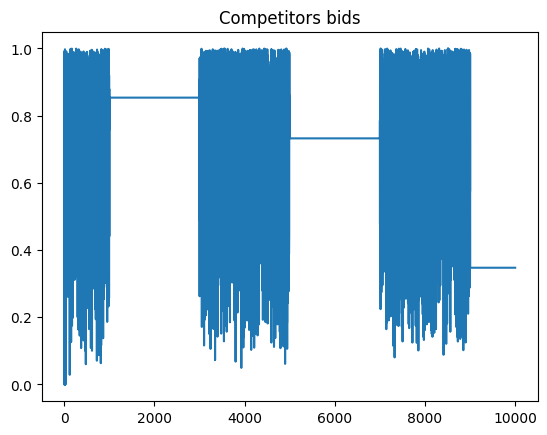

In [3]:
plt.plot(m_t)
plt.title('Competitors bids')
plt.show()

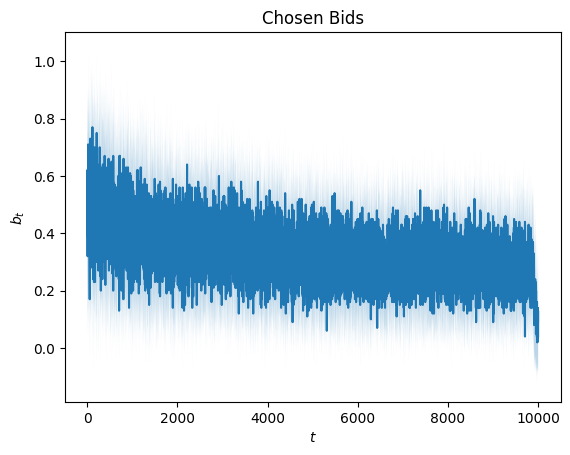

In [63]:
plt.plot(np.arange(n_users), avg_my_bids)
plt.fill_between(np.arange(n_users), avg_my_bids-std_my_bids, avg_my_bids+std_my_bids, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$b_t$')
plt.title('Chosen Bids')
plt.show()

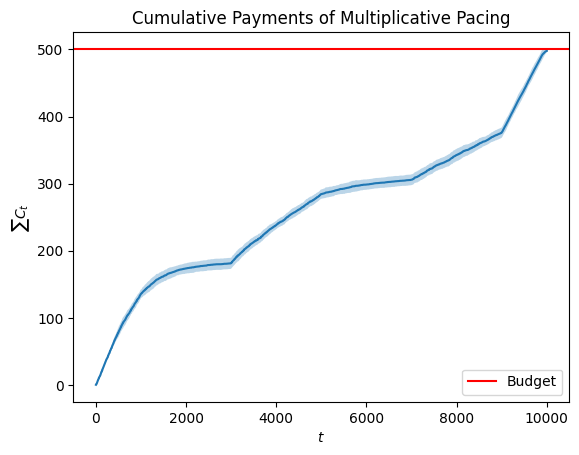

In [64]:
plt.plot(np.arange(n_users), avg_payments)
plt.fill_between(np.arange(n_users), avg_payments-std_payments, avg_payments+std_payments, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum C_t$')
plt.axhline(Budget, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Multiplicative Pacing')
plt.show()

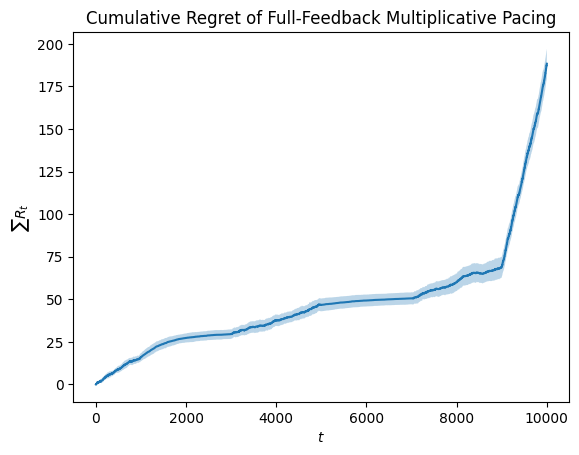

In [65]:
plt.plot(np.arange(n_users), avg_regret, label='Average Regret')
plt.fill_between(np.arange(n_users), avg_regret-std_regret, avg_regret+std_regret, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of Full-Feedback Multiplicative Pacing')
plt.show()

# Putting all pieces together

In [104]:
# bidding parameters
days = 365
n_users = 500
n_advertisers = 6
ctrs = np.ones(n_advertisers)
Budget = 5000
my_valuation=0.6
eta = 1/np.sqrt(n_users*days)
rho = Budget/(n_users*days)

# pricing parameters
epsilon = days**(-0.33)
K = int(1/epsilon)
learning_rate = np.sqrt(np.log(K)/days)
prices = np.linspace(0,1,K)
cost = 0.1

# generate daily demand curves 
conversion_rates = []
random_steeps = np.random.uniform(1,5,days)
conversion_rates = [demand.generate_demand(0,1,steep) for steep in random_steeps]

# find best price in hindsight
loss_profit_curve = []
profit_curve = []
for t in range(days):
    loss_profit_curve.append([(1-(price-cost)*conversion_rates[t](price)) for price in prices])
    profit_curve.append([(price-cost)*conversion_rates[t](price) for price in prices])
loss_profit_curve = np.array(loss_profit_curve)
profit_curve = np.array(profit_curve)
summed_losses = np.sum(loss_profit_curve, axis=0)
summed_profits = np.sum(profit_curve, axis=0)
best_price_index = np.argmin(summed_losses)
best_price = prices[best_price_index]
expected_max_profit = np.max(summed_profits) # in hindsight

# logging
user_bids_won = np.zeros(days)
clair_bids_won = np.zeros(days)
pricing_profit = np.zeros(days)
clair_pricing_profit = np.zeros(days)
my_payments = np.array([])
clair_payments = np.array([])
my_bids = np.array([])
utilities = np.array([])
expected__pricing_pseudo_regret = np.zeros(days)

# agents,envs
bidding_agent = FFMultiplicativePacingAgent(np.linspace(0,1,11),my_valuation,Budget,n_users*days,eta)
auction = FirstPriceAuction(np.ones(n_advertisers+1))
pricing_env = PricingEnvironment(conversion_probability=conversion_rates, cost=cost, prices=prices)
pricing_agent = HedgeAgent(K,learning_rate)

# Generate competing bids
np.random.seed(6)
other_bids = np.array([generate_bids(n_advertisers, np.random.normal(0.5, 5), t) for t in range(n_users*days)]).T
# add an additional non stationary component
other_bids[:,18250:54750] = np.random.uniform(0.70,0.90)
other_bids[:,91250:127750] = np.random.uniform(0.65,0.75)
other_bids[:,164250:] = np.random.uniform(0.65,0.75)
m_t = other_bids.max(axis=0)

# Adversarial clairvoyant
available_bids = np.linspace(0,1,11)
win_probabilities = np.array([sum(b > m_t)/(n_users*days) for b in available_bids])
c = -(my_valuation-available_bids)*win_probabilities
A_ub = [available_bids*win_probabilities]
b_ub = [rho]
A_eq = [np.ones(len(available_bids))]
b_eq = [1]
res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
gamma = res.x
expected_clairvoyant_utilities = [-res.fun for u in range(n_users*days)]
expected_clairvoyant_bids = [sum(available_bids*gamma*win_probabilities) for u in range(n_users*days)]
expectded_clairvoyant_payments = [sum(available_bids*gamma*win_probabilities) for u in range(n_users*days)]
clairvoyant_bids = np.random.choice(available_bids, n_users*days, p=gamma)
clairvoyant_payments = [(clairvoyant_bids[u]*int(clairvoyant_bids[u] >= m_t[u])) for u in range(n_users*days)]
clairvoyant_utilities = [(my_valuation-m_t[u])*int(clairvoyant_bids[u] >= m_t[u]) for u in range(n_users*days)]


# Main loop
for d in range(days):
    
    ## Bidding step
    bids_won = 0
    tot_bidding_cost = 0
    daily_bids = other_bids[:, d*n_users:(d+1)*n_users]

    for u in range(n_users):
        # Single bid interaction
        my_bid = bidding_agent.bid()
        my_bids = np.append(my_bids, my_bid)
        bids = np.append(my_bid, daily_bids[:, u].ravel())
        winners, payments_per_click = auction.round(bids=bids)
        my_win = int(winners==0)
        f_t, c_t = (my_valuation-m_t[d*u])*my_win, m_t[d*u]*my_win
        bids_won += my_win
        tot_bidding_cost += c_t
        utilities = np.append(utilities, f_t)
        #update bidding agent
        bidding_agent.update(f_t, c_t, m_t[d*u])
    user_bids_won[d] = bids_won

    my_payments = np.append(my_payments, tot_bidding_cost)


    ## Pricing step
    price_i = pricing_agent.pull_arm()
    price = prices[price_i]
    
    if bids_won>0:
            l_t, r_t, d_t = pricing_env.round(price, bids_won, d)
            pricing_agent.update(l_t)
    else: 
        r_t = 0
    pricing_profit[d] = r_t
    expected__pricing_pseudo_regret[d]=(bids_won*expected_max_profit)-(conversion_rates[d](price)*bids_won)

    # clairvoyant profit
    clair_daily_payments = clairvoyant_payments[d*n_users:(d+1)*n_users]
    clair_true_payments = np.count_nonzero(clair_daily_payments)
    clair_l_t , clair_r_t, clair_d_t = pricing_env.round(best_price, clair_true_payments, d)
    clair_pricing_profit[d] = clair_r_t
    tot_clair_daily_payments = sum(clair_daily_payments)
    clair_payments = np.append(clair_payments, tot_clair_daily_payments)
    clair_bids_won[d] = clair_true_payments


# Cumulative final results
cumulative_payments = np.cumsum(my_payments)
cumulative_clair_payments = np.cumsum(clair_payments)
user_bids_won = np.cumsum(user_bids_won)
clair_bids_won = np.cumsum(clair_bids_won)
pricing_profit = np.cumsum(pricing_profit)
clair_pricing_profit = np.cumsum(clair_pricing_profit)
utilities = np.cumsum(utilities)
clairvoyant_utilities = np.cumsum(clairvoyant_utilities)

# regrets
expected__pricing_pseudo_regret = np.cumsum(expected__pricing_pseudo_regret)
cumulative_pricing_regret = clair_pricing_profit - pricing_profit
cumulative_bidding_regret = clairvoyant_utilities - utilities


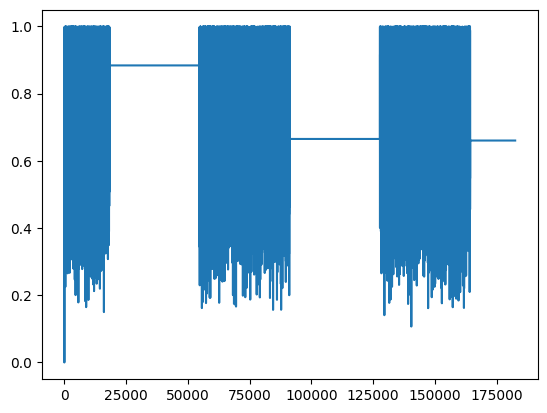

In [105]:
plt.plot(m_t)

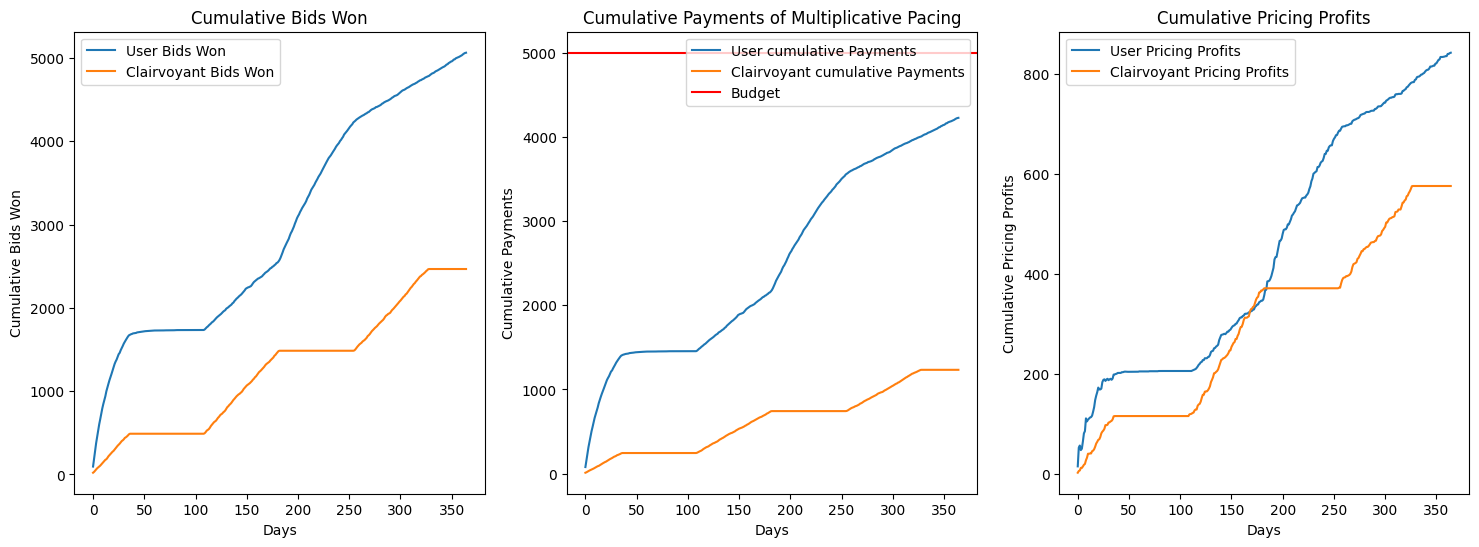

In [106]:
fig, ax = plt.subplots(1,3, figsize=(18,6))
ax[0].plot(np.arange(days), user_bids_won, label='User Bids Won')
ax[0].plot(np.arange(days), clair_bids_won, label='Clairvoyant Bids Won')
ax[0].set_xlabel('Days')
ax[0].set_ylabel('Cumulative Bids Won')
ax[0].legend()
ax[0].set_title('Cumulative Bids Won')

ax[1].plot(np.arange(days), cumulative_payments, label='User cumulative Payments')
ax[1].plot(np.arange(days), cumulative_clair_payments, label='Clairvoyant cumulative Payments')
ax[1].axhline(Budget, color='red', label='Budget')
ax[1].set_xlabel('Days')
ax[1].set_ylabel('Cumulative Payments')
ax[1].set_title('Cumulative Payments of Multiplicative Pacing')
ax[1].legend()

ax[2].plot(np.arange(days), pricing_profit, label='User Pricing Profits')
ax[2].plot(np.arange(days), clair_pricing_profit, label='Clairvoyant Pricing Profits')
ax[2].set_xlabel('Days')
ax[2].set_ylabel('Cumulative Pricing Profits')
ax[2].set_title('Cumulative Pricing Profits')
ax[2].legend()
plt.show()

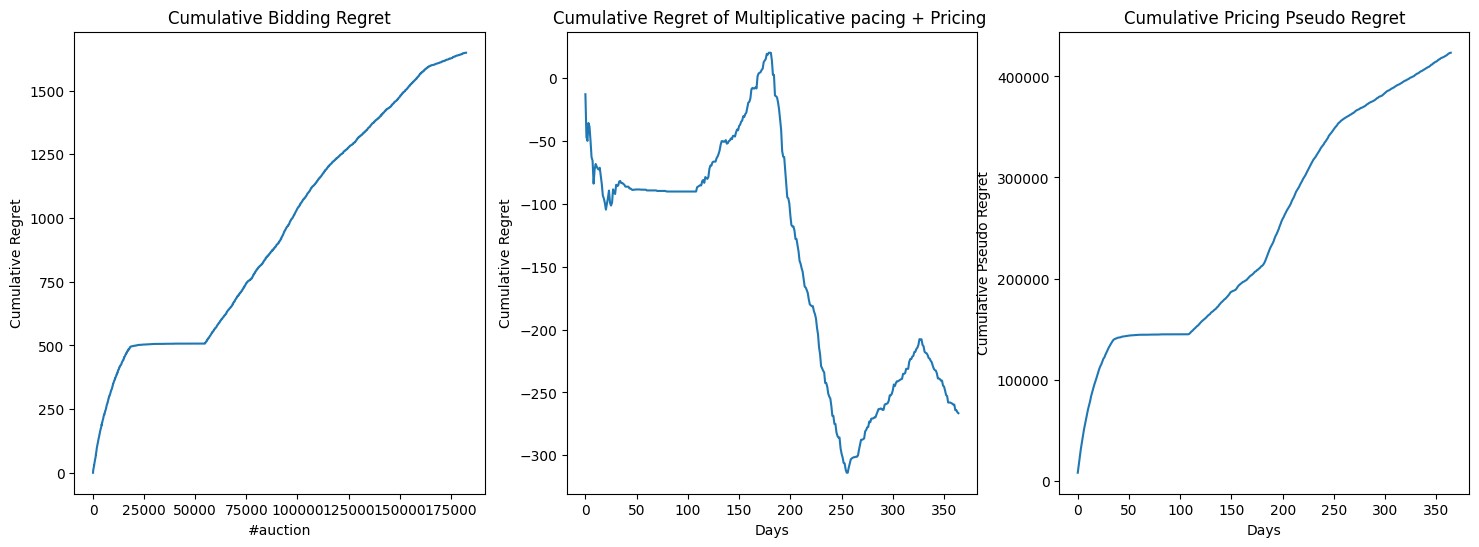

In [108]:
# plot the 3 regrets with subplots
fig, ax = plt.subplots(1,3, figsize=(18,6))
ax[0].plot(np.arange(days*n_users), cumulative_bidding_regret, label='Bidding Regret')
ax[0].set_xlabel('#auction')
ax[0].set_ylabel('Cumulative Regret')
ax[0].set_title('Cumulative Bidding Regret')

ax[1].plot(np.arange(days), cumulative_pricing_regret, label='Pricing Regret')
ax[1].set_xlabel('Days')
ax[1].set_ylabel('Cumulative Regret')
ax[1].set_title('Cumulative Regret of Multiplicative pacing + Pricing ')

ax[2].plot(np.arange(days), expected__pricing_pseudo_regret, label='Pricing Pseudo Regret')
ax[2].set_xlabel('Days')
ax[2].set_ylabel('Cumulative Pseudo Regret')
ax[2].set_title('Cumulative Pricing Pseudo Regret')
plt.show()

In [ ]:
#TODO capisco se posso migliorare grafici e se c'è un errore nel pseudo che sembra troppo alto